In [1]:
%run using_func.ipynb

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns、plt繪圖中文字顯示問題處理
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# 確認核心問題「回購率是否增長」

---

透過 YoY（年成長率） 了解今年度新客回購率相較於去年度是否有成長

## 1. 2021、2022新客數、回購數 

In [3]:
conn = conn_login()
cursor = conn.cursor()

# Total
cursor.execute('''
    SELECT firsttransactionyear, count(customerid) as `Total_count`
        From table1_Customers
            GROUP by firsttransactionyear;
''')
res1 = cursor.fetchall()
res = fetchall_TO_DF(res1)

# 2021 repurchas
cursor.execute('''
SELECT count(`count`) AS `sum`
    FROM (
        SELECT `customerid`, COUNT(orderid) AS `count`
        FROM table2_Orders
        WHERE transactionyear = 2021
        GROUP BY customerid
        HAVING COUNT(orderid) >= 2
    ) AS sub
    JOIN table1_Customers t1
        ON t1.`customerid` = sub.`customerid`
            where firsttransactionyear = 2021
''')
res2 = cursor.fetchall()

# 2022 repurchas
cursor.execute('''
SELECT count(`count`) AS `sum`
    FROM (
        SELECT `customerid`, COUNT(orderid) AS `count`
        FROM table2_Orders
        WHERE transactionyear = 2022
        GROUP BY customerid
        HAVING COUNT(orderid) >= 2
    ) AS sub
    JOIN table1_Customers t1
        ON t1.`customerid` = sub.`customerid`
            where firsttransactionyear = 2022
''')
res3 = cursor.fetchall()

res['repurchas'] = [res2[0][0], res3[0][0]]
res['repurchas ratio(%)'] = round(res['repurchas'] * 100 / res['Total_count'], 2)

new_row = ['YoY(%)',
           round((res.at[1,'Total_count'] - res.at[0,'Total_count'])*100/res.at[0,'Total_count'], 2),
           round((res.at[1,'repurchas'] - res.at[0,'repurchas'])*100/res.at[0,'repurchas'], 2),
           round((res.at[1,'repurchas ratio(%)'] - res.at[0,'repurchas ratio(%)'])*100/res.at[0,'repurchas ratio(%)'], 2)]
res.loc[2] = new_row
res

,firsttransactionyear,Total_count,repurchas,repurchas ratio(%)
0,2021,8284.00,1276.00,15.40
1,2022,9636.00,1621.00,16.82
2,YoY(%),16.32,27.04,9.22


## 2. 各通路回購量

In [6]:
cursor.execute('''
WITH cpe1 AS (
  SELECT customerid, channel, COUNT(orderid) AS `回購次數`
  FROM table2_Orders
  WHERE transactionyear = 2022
  GROUP BY customerid, channel
  HAVING COUNT(orderid) >= 2
),
cpe2 AS (
  SELECT `回購次數`, COUNT(`回購次數`) AS `回購量`
  FROM cpe1
  GROUP BY `回購次數`
)
SELECT cpe1.channel, COUNT(cpe1.channel) AS '各通路回購量'
FROM cpe1
JOIN table1_Customers t1 ON t1.customerid = cpe1.customerid
WHERE t1.firsttransactionyear = 2022
GROUP BY cpe1.channel
''')
res = cursor.fetchall()
channel_2022 = fetchall_TO_DF(res)

cursor.execute('''
WITH cpe1 AS (
  SELECT customerid, channel, COUNT(orderid) AS `回購次數`
  FROM table2_Orders
  WHERE transactionyear = 2021
  GROUP BY customerid, channel
  HAVING COUNT(orderid) >= 2
),
cpe2 AS (
  SELECT `回購次數`, COUNT(`回購次數`) AS `回購量`
  FROM cpe1
  GROUP BY `回購次數`
)
SELECT cpe1.channel, COUNT(cpe1.channel) AS '各通路回購量'
FROM cpe1
JOIN table1_Customers t1 ON t1.customerid = cpe1.customerid
WHERE t1.firsttransactionyear = 2021
GROUP BY cpe1.channel
''')

res = cursor.fetchall()
channel_2021 = fetchall_TO_DF(res)

In [7]:
res = channel_2021.merge(channel_2022, on='channel', how='outer', suffixes=('2021', '2022'))
# res['各通路回購量2021'] = res['各通路回購量2021'].astype(int)

# 補其他也是0的分店
name = ['台南西門門市', '新竹遠東門市', '桃園台茂門市']
for i,v in enumerate(name):
    res.loc[10 + i,'channel'] = v
res = res.fillna(0)

In [8]:
res

,channel,各通路回購量2021,各通路回購量2022
0,台北統一門市,30.0,51.0
1,台北信義門市,47.0,67.0
2,官網,823.0,909.0
3,台北南西門市,31.0,50.0
4,新竹巨城門市,38.0,63.0
5,台北京站門市,39.0,13.0
6,台中勤美門市,43.0,53.0
7,高雄巨蛋門市,23.0,43.0
8,台北敦南門市,3.0,108.0
9,台中中港門市,0.0,32.0


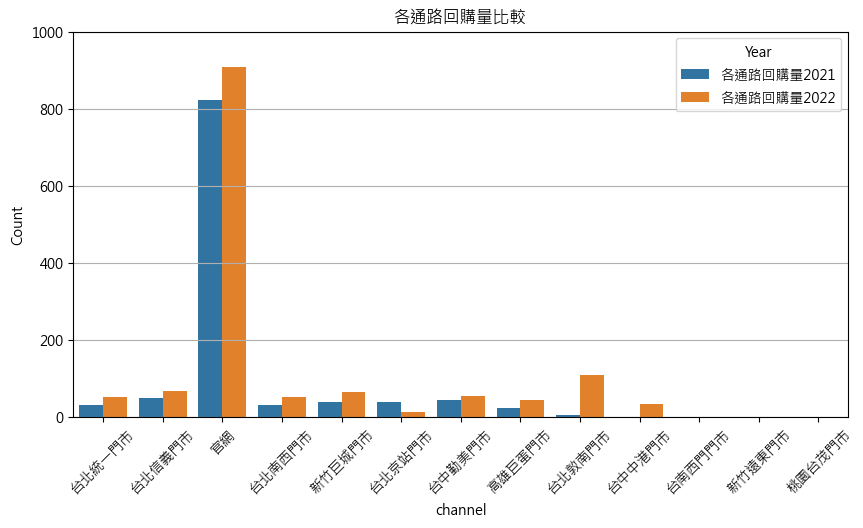

In [9]:
# 產生新DF for作圖
df_melted = pd.melt(res, id_vars='channel', value_vars=['各通路回購量2021', '各通路回購量2022'], var_name='Year', value_name='Count')

plt.figure(figsize=(10, 5))
sns.barplot(x='channel', y='Count', hue='Year', data=df_melted)
plt.ylabel('Count')
plt.title('各通路回購量比較')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.grid(axis='y')
plt.ylim(0, 1000)
plt.show()

# 驗證回購與否與「首購產品類型」有關
---
* 每一次的首購經驗往往會影響後續的回購機會
* 以過去的銷售經驗來看，有買核心產品的客人回購率比較高

## 1.計算 2021～2022 年 1-4 月新客首購中，購買的產品的類別分佈，並計算購買行為成長率

In [10]:
def trans_df(df1, df2):
    # 回購率
    df1['回購率(%)'] = round(df1['回購量'] * 100 / df1['購買數'], 2)
    df2['回購率(%)'] = round(df2['回購量'] * 100 / df2['購買數'], 2)

    # index reset
    df1.set_index('Type', inplace=True)
    df2.set_index('Type', inplace=True)

    # concat
    res = pd.concat([df1, df2], axis=1, keys=['2021', '2022'])


    # YoY
    res[('YoY', '購買數')] = round((res[('2022', '購買數')] - res[('2021', '購買數')]) * 100 / res[('2021', '購買數')], 2)
    res[('YoY', '回購量')] = round((res[('2022', '回購量')] - res[('2021', '回購量')]) * 100 / res[('2021', '回購量')], 2)
    res[('YoY', '回購率(%)')] = round((res[('2022', '回購率(%)')] - res[('2021', '回購率(%)')]) * 100 / res[('2021', '回購率(%)')], 2)

    return res

In [11]:
cursor.execute('''
WITH cpe1 AS (
SELECT
   t1.customerid,
   t1.FirstTransactionDate
	FROM table1_Customers t1
    LEFT JOIN table2_Orders t2
  		ON t1.customerid = t2.customerid
        	AND t1.FirstTransactionDate = t2.TransactionDate
    LEFT JOIN table3_OrderDetails t3
      	ON t2.orderid = t3.orderid
	LEFT JOIN table4_Products t4 
		ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='核心產品') AS pc
        ON t3.productid = pc.productid
WHERE pc.productid IS NOT NULL
),
cpe2 AS (
SELECT
  t1.customerid,
  t1.FirstTransactionDate
	FROM table1_Customers t1
	LEFT JOIN table2_Orders t2
		ON t1.customerid = t2.customerid
			AND t1.FirstTransactionDate = t2.TransactionDate
	LEFT JOIN table3_OrderDetails t3
		ON t2.orderid = t3.orderid
    LEFT JOIN table4_Products t4 
    	ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='帶路產品') AS pr
    	ON t3.productid = pr.productid
WHERE pr.productid IS Not NULL
)

SELECT
  firsttransactionyear,
  COUNT(DISTINCT t1.customerid) AS cnt
  FROM table1_Customers t1
    LEFT JOIN cpe1 
    	On t1.customerid = cpe1.customerid 
    LEFT JOIN cpe2 
    	On t1.customerid = cpe2.customerid 
WHERE cpe1.customerid IS not NULL
	AND cpe2.customerid IS not NULL
GROUP BY 1
''')
res = cursor.fetchall()
fetchall_TO_DF(res)

,firsttransactionyear,cnt
0,2021,833
1,2022,941


In [10]:
cursor.execute('''
WITH cpe1 AS (
SELECT
   t1.customerid,
   t1.FirstTransactionDate
	FROM table1_Customers t1
    LEFT JOIN table2_Orders t2
  		ON t1.customerid = t2.customerid
        	AND t1.FirstTransactionDate = t2.TransactionDate
    LEFT JOIN table3_OrderDetails t3
      	ON t2.orderid = t3.orderid
	LEFT JOIN table4_Products t4 
		ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='核心產品') AS pc
        ON t3.productid = pc.productid
WHERE pc.productid IS NOT NULL
),
cpe2 AS (
SELECT
  t1.customerid,
  t1.FirstTransactionDate
	FROM table1_Customers t1
	LEFT JOIN table2_Orders t2
		ON t1.customerid = t2.customerid
			AND t1.FirstTransactionDate = t2.TransactionDate
	LEFT JOIN table3_OrderDetails t3
		ON t2.orderid = t3.orderid
    LEFT JOIN table4_Products t4 
    	ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='帶路產品') AS pr
    	ON t3.productid = pr.productid
WHERE pr.productid IS Not NULL
),
cpe3 as (
SELECT
  customerid,
  transactionyear,
  count(distinct orderid) as order_cnt
  FROM table2_Orders
  GROUP BY customerid,transactionyear
)

SELECT
  t1.firsttransactionyear,
  COUNT(DISTINCT rep.customerid) AS cnt
  FROM table1_Customers t1
    LEFT JOIN (SELECT * from cpe3 where order_cnt >= 2) rep
    	on rep.customerid = t1.customerid
        	and t1.firsttransactionyear = rep.transactionyear
    LEFT JOIN cpe1 
    	On t1.customerid = cpe1.customerid 
    LEFT JOIN cpe2 
    	On t1.customerid = cpe2.customerid 
WHERE cpe1.customerid IS not NULL
	AND cpe2.customerid IS NULL
GROUP BY t1.firsttransactionyear
''')

In [12]:
# 透過改變條件獲得不同類型首購購買數量、回購數量
res2021 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                '買帶路產品無核心產品',
                                '核心、帶路產品都買',
                                '只買其他產品',
                                '總數'],
                        '購買數':[3800, 2645, 833, 1006, 8284],
                        '回購量':[626, 330, 167, 153, 1276]})

res2022 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                '買帶路產品無核心產品',
                                '核心、帶路產品都買',
                                '只買其他產品',
                                '總數'],
                        '購買數':[4013, 3471, 941, 1211, 9636],
                        '回購量':[935, 297, 210, 179, 1621]})
res2021['回購率(%)'] = round(res2021['回購量'] * 100 / res2021['購買數'], 2)
res2022['回購率(%)'] = round(res2022['回購量'] * 100 / res2022['購買數'], 2)

In [13]:
res = trans_df(res2021, res2022)
res

2021               2022                 YoY              
             購買數   回購量 回購率(%)   購買數   回購量 回購率(%)    購買數    回購量 回購率(%)
Type                                                                 
買核心產品無帶路產品  3800   626  16.47  4013   935  23.30   5.61  49.36  41.47
買帶路產品無核心產品  2645   330  12.48  3471   297   8.56  31.23 -10.00 -31.41
核心、帶路產品都買    833   167  20.05   941   210  22.32  12.97  25.75  11.32
只買其他產品      1006   153  15.21  1211   179  14.78  20.38  16.99  -2.83
總數          8284  1276  15.40  9636  1621  16.82  16.32  27.04   9.22

# 驗證首購品項與「通路」有關
---
* 細看不同通路是否影響客戶的首購行為

* 不同通路的消費體驗、售後體驗可能不同，因此，想藉由比較不同通路的購買狀況，做更深入的分析

* 不同通路藉由不同條件限制得出

## 1. 線上與線下通路購買數(線上為例)

In [14]:
# 線上購買數
cursor.execute('''
WITH cpe1 AS (
  SELECT t1.customerId,
         t1.firsttransactionyear,
         t2.orderid,
         COUNT(DISTINCT t2.orderid) AS cnt
	FROM table1_Customers t1
    LEFT JOIN table2_Orders t2
    	ON t1.customerid = t2.customerid
  WHERE t1.firsttransactionyear = t2.TransactionYear
  	AND t1.firstchannel = '官網'
  GROUP BY t1.customerId, t1.firsttransactionyear, t2.orderid
)
SELECT cpe1.firsttransactionyear, COUNT(cpe1.orderid) AS cnt
	FROM cpe1
    GROUP BY cpe1.firsttransactionyear


''')
res = cursor.fetchall()
fetchall_TO_DF(res)

,firsttransactionyear,cnt
0,2022,8535
1,2021,7339


## 2.回購數(線上為例)

In [15]:
cursor.execute('''
WITH cpe1 AS (
  SELECT t1.customerId,
         t1.firsttransactionyear,
         COUNT(DISTINCT t2.orderid) AS rep
	FROM table1_Customers t1
    LEFT JOIN table2_Orders t2
    	ON t1.customerid = t2.customerid
  WHERE t1.firsttransactionyear = t2.TransactionYear
  	AND t1.firstchannel = '官網'
  GROUP BY t1.customerId, t1.firsttransactionyear
)
SELECT cpe1.firsttransactionyear,
       COUNT(cpe1.customerId) AS rep_count
FROM cpe1
where cpe1.rep > 1
GROUP BY cpe1.firsttransactionyear
''')
res = cursor.fetchall()
fetchall_TO_DF(res)

,firsttransactionyear,rep_count
0,2022,988
1,2021,849


## 3. 不同首購商品+通路在這2年的新客數及回購數(線上為例)

In [ ]:
cursor.execute('''
WITH cpe1 AS (
SELECT
   t1.customerid,
   t1.FirstTransactionDate
	FROM table1_Customers t1
    LEFT JOIN table2_Orders t2
  		ON t1.customerid = t2.customerid
        	AND t1.FirstTransactionDate = t2.TransactionDate
    LEFT JOIN table3_OrderDetails t3
      	ON t2.orderid = t3.orderid
	LEFT JOIN table4_Products t4 
		ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='核心產品') AS pc
        ON t3.productid = pc.productid
WHERE pc.productid IS NOT NULL
),
cpe2 AS (
SELECT
  t1.customerid,
  t1.FirstTransactionDate
	FROM table1_Customers t1
	LEFT JOIN table2_Orders t2
		ON t1.customerid = t2.customerid
			AND t1.FirstTransactionDate = t2.TransactionDate
	LEFT JOIN table3_OrderDetails t3
		ON t2.orderid = t3.orderid
    LEFT JOIN table4_Products t4 
    	ON t3.productid = t4.productid
    LEFT JOIN (SELECT * FROM table4_Products t4 WHERE ProductType ='帶路產品') AS pr
    	ON t3.productid = pr.productid
WHERE pr.productid IS Not NULL
),
cpe3 as (
SELECT
  customerid,
  transactionyear,
  count(distinct orderid) as order_cnt
  FROM table2_Orders
  GROUP BY 1,2
)

SELECT
  t1.firsttransactionyear,
  COUNT(DISTINCT t1.customerid) AS cnt,
  COUNT(DISTINCT rep.customerid) AS cnt
  FROM table1_Customers t1
    LEFT JOIN (SELECT * from cpe3 where order_cnt >= 2) rep
    	on rep.customerid = t1.customerid
        	and t1.firsttransactionyear = rep.transactionyear
    LEFT JOIN cpe1 
    	On t1.customerid = cpe1.customerid 
    LEFT JOIN cpe2 
    	On t1.customerid = cpe2.customerid 
WHERE cpe1.customerid IS  NULL
	AND cpe2.customerid IS not NULL
    AND t1.firstchannel = '官網'
GROUP BY 1
''')

## 取得各通路首購回購數量後

In [16]:
res2022 = pd.DataFrame({'Type':['Online', 'Non-Online'],
                        '購買數':[7306, 2330],
                        '回購量':[988, 633]})
res2021 = pd.DataFrame({'Type':['Online', 'Non-Online'],
                        '購買數':[6244, 2040],
                        '回購量':[849, 427]})
res = trans_df(res2021, res2022)
res

2021              2022                YoY              
             購買數  回購量 回購率(%)   購買數  回購量 回購率(%)    購買數    回購量 回購率(%)
Type                                                               
Online      6244  849  13.60  7306  988  13.52  17.01  16.37  -0.59
Non-Online  2040  427  20.93  2330  633  27.17  14.22  48.24  29.81

In [17]:
# Online、non-Online
Onlineres2021 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                      '買帶路產品無核心產品',
                                      '核心、帶路產品都買',
                                      '只買其他產品',
                                      '總數'],
                                      '購買數':[2844, 2079, 634, 687, 6244],
                                      '回購量':[402, 244, 111, 92, 849]})

Onlineres2022 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                          '買帶路產品無核心產品',
                                          '核心、帶路產品都買',
                                          '只買其他產品',
                                          '總數'],
                                          '購買數':[2995, 2769, 713, 829, 7306],
                                          '回購量':[587, 182, 129, 90, 988]})

Non_Onlineres2021 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                      '買帶路產品無核心產品',
                                      '核心、帶路產品都買',
                                      '只買其他產品',
                                      '總數'],
                                      '購買數':[956, 566, 199, 319, 2040],
                                      '回購量':[224, 86, 56, 61, 427]})

Non_Onlineres2022 = pd.DataFrame({'Type':['買核心產品無帶路產品',
                                          '買帶路產品無核心產品',
                                          '核心、帶路產品都買',
                                          '只買其他產品',
                                          '總數'],
                                          '購買數':[1018, 702, 228, 382, 2330],
                                          '回購量':[348, 115, 81, 89, 633]})

Online_res = trans_df(Onlineres2021, Onlineres2022)
Non_Online_res = trans_df(Non_Onlineres2021, Non_Onlineres2022)

In [18]:
print('Online_res')
display(Online_res)

print('Non_Online_res')
display(Non_Online_res)

Online_res


2021              2022                YoY              
             購買數  回購量 回購率(%)   購買數  回購量 回購率(%)    購買數    回購量 回購率(%)
Type                                                               
買核心產品無帶路產品  2844  402  14.14  2995  587  19.60   5.31  46.02  38.61
買帶路產品無核心產品  2079  244  11.74  2769  182   6.57  33.19 -25.41 -44.04
核心、帶路產品都買    634  111  17.51   713  129  18.09  12.46  16.22   3.31
只買其他產品       687   92  13.39   829   90  10.86  20.67  -2.17 -18.89
總數          6244  849  13.60  7306  988  13.52  17.01  16.37  -0.59

Non_Online_res


2021              2022                YoY              
             購買數  回購量 回購率(%)   購買數  回購量 回購率(%)    購買數    回購量 回購率(%)
Type                                                               
買核心產品無帶路產品   956  224  23.43  1018  348  34.18   6.49  55.36  45.88
買帶路產品無核心產品   566   86  15.19   702  115  16.38  24.03  33.72   7.83
核心、帶路產品都買    199   56  28.14   228   81  35.53  14.57  44.64  26.26
只買其他產品       319   61  19.12   382   89  23.30  19.75  45.90  21.86
總數          2040  427  20.93  2330  633  27.17  14.22  48.24  29.81

## YoY繪圖

In [19]:
Online_YoY = Online_res['YoY']
Non_Online_YoY = Non_Online_res['YoY']

In [20]:
def yoy_plt(df_online, df_Nononline, target, ax = None):
    yoy = pd.concat([df_online[target], df_Nononline[target]], axis=1, keys=['Online', 'Non_Online'])
    melted = yoy.reset_index().melt(id_vars='Type', var_name='Channel', value_name='YoY')
    sns.barplot(melted, x='Type', y='YoY', hue='Channel',ax=ax)
    ax.set_title(f'{target} YoY')
    ax.set_xlabel('Type')
    ax.set_ylabel('YoY(%)')
    ax.tick_params(axis='x', rotation=45)

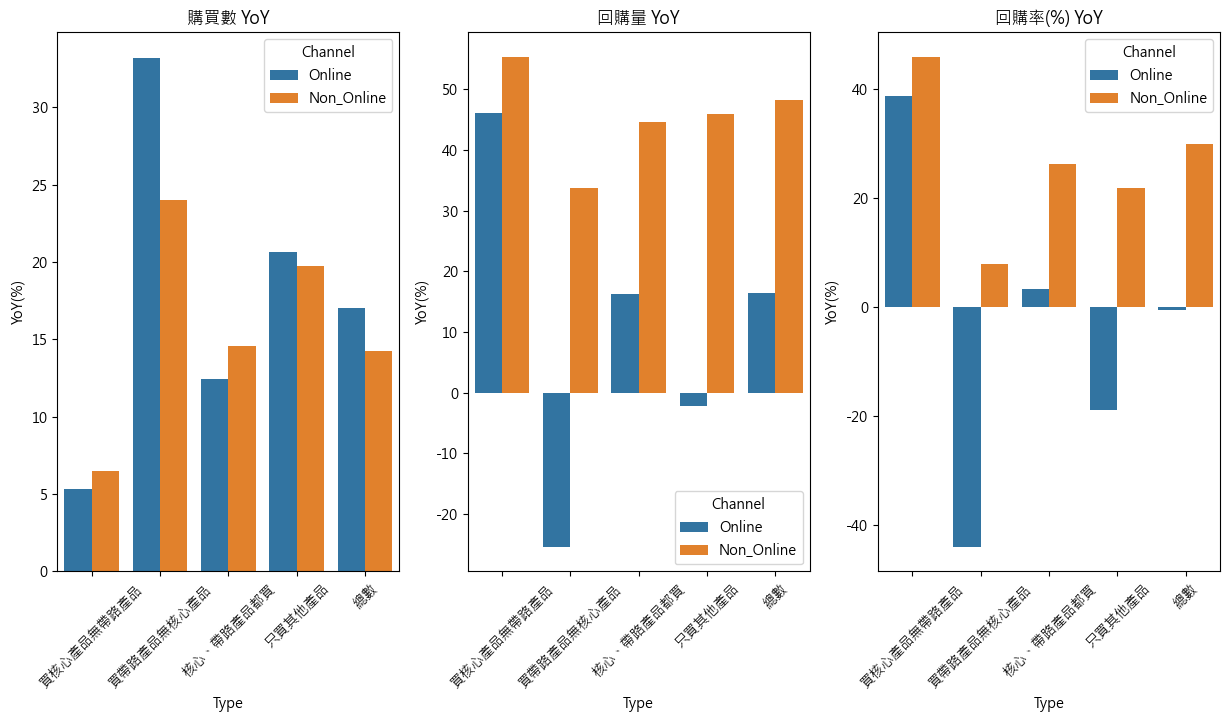

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
titles = ['購買數', '回購量', '回購率(%)']
for i, t in enumerate(titles):
    yoy_plt(Online_YoY, Non_Online_YoY, t, ax=axes[i])
plt.show()
